In [155]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm

import sklearn

from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

from sklearn.manifold import TSNE

In [3]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2021-10-01 19:16:16--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 60302 (59K) [text/plain]
Сохранение в: «titanic.csv.5»

titanic.csv.5       100%[===================>]  58,89K  --.-KB/s    за 0,08s   

2021-10-01 19:16:16 (763 KB/s) - «titanic.csv.5» сохранён [60302/60302]



## Загружаем данные

In [4]:
data = pd.read_csv('titanic.csv')
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Смотрим распределения

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


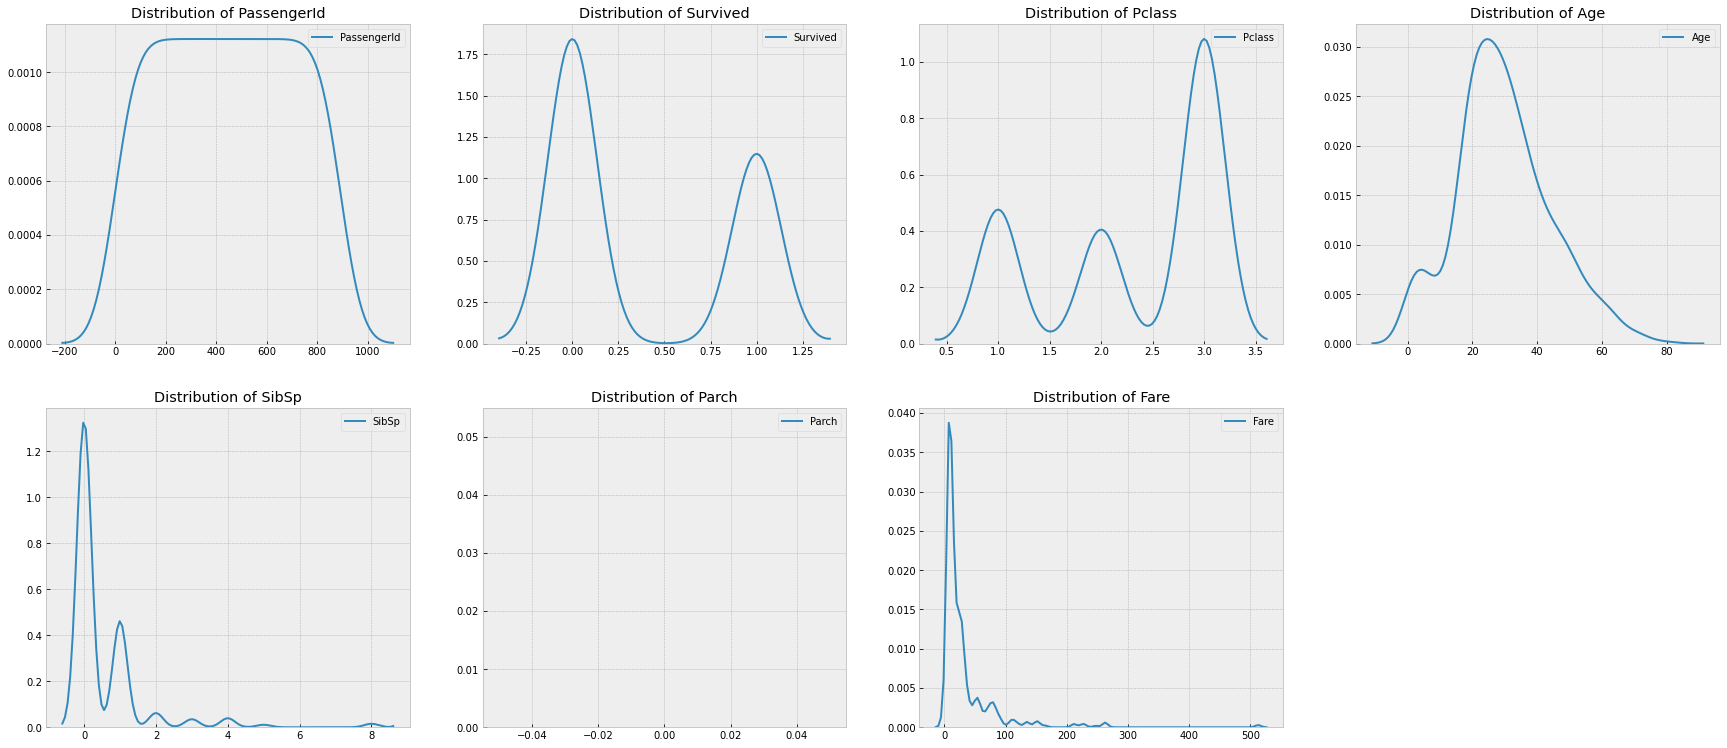

In [5]:
plt.figure(figsize=(30, 20))
plt.style.use('bmh')

num = 0
for col in data.columns:
    
    if data[col].dtype == 'object':
        continue
    num += 1
    plt.subplot(3, 4, num)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(data[col])

### Если распределение не построилось, строим гистаграмму

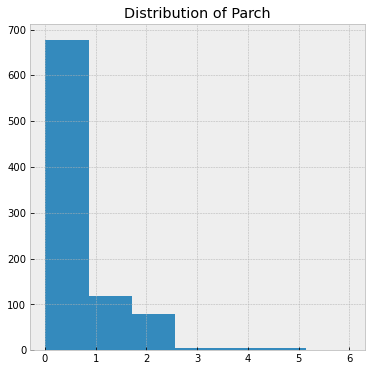

In [6]:
plt.figure(figsize=(6, 6))
plt.title('Distribution of Parch')
plt.hist(data['Parch'], bins=data['Parch'].nunique())
plt.show()

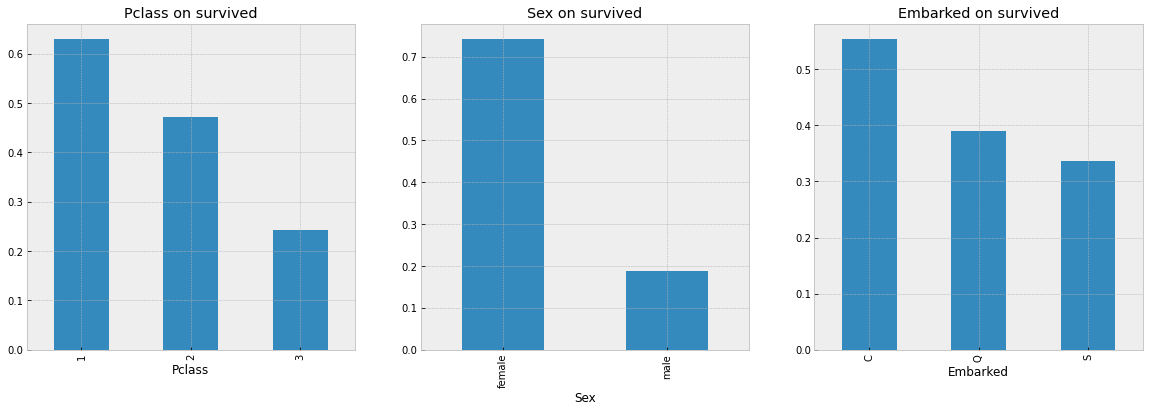

In [7]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title('Pclass on survived')
data.groupby('Pclass')['Survived'].mean().plot.bar()

plt.subplot(1, 3, 2)
plt.title('Sex on survived')
data.groupby('Sex')['Survived'].mean().plot.bar()

plt.subplot(1, 3, 3)
plt.title('Embarked on survived')
data.groupby('Embarked')['Survived'].mean().plot.bar()

plt.show()

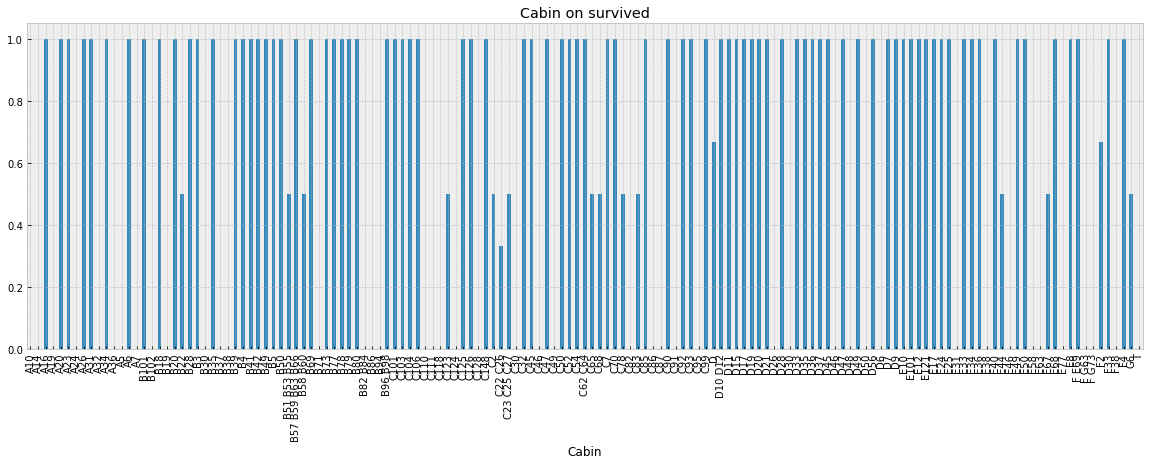

In [8]:
plt.figure(figsize=(20, 6))

plt.title('Cabin on survived')
data.groupby('Cabin')['Survived'].mean().plot.bar()

plt.show()

### Смотрим, сколько численных и категориальных признаков

In [9]:
print('Num of numeric feats:', num)
print('Num of categorical feats:', len(data.columns) - num)

Num of numeric feats: 7
Num of categorical feats: 5


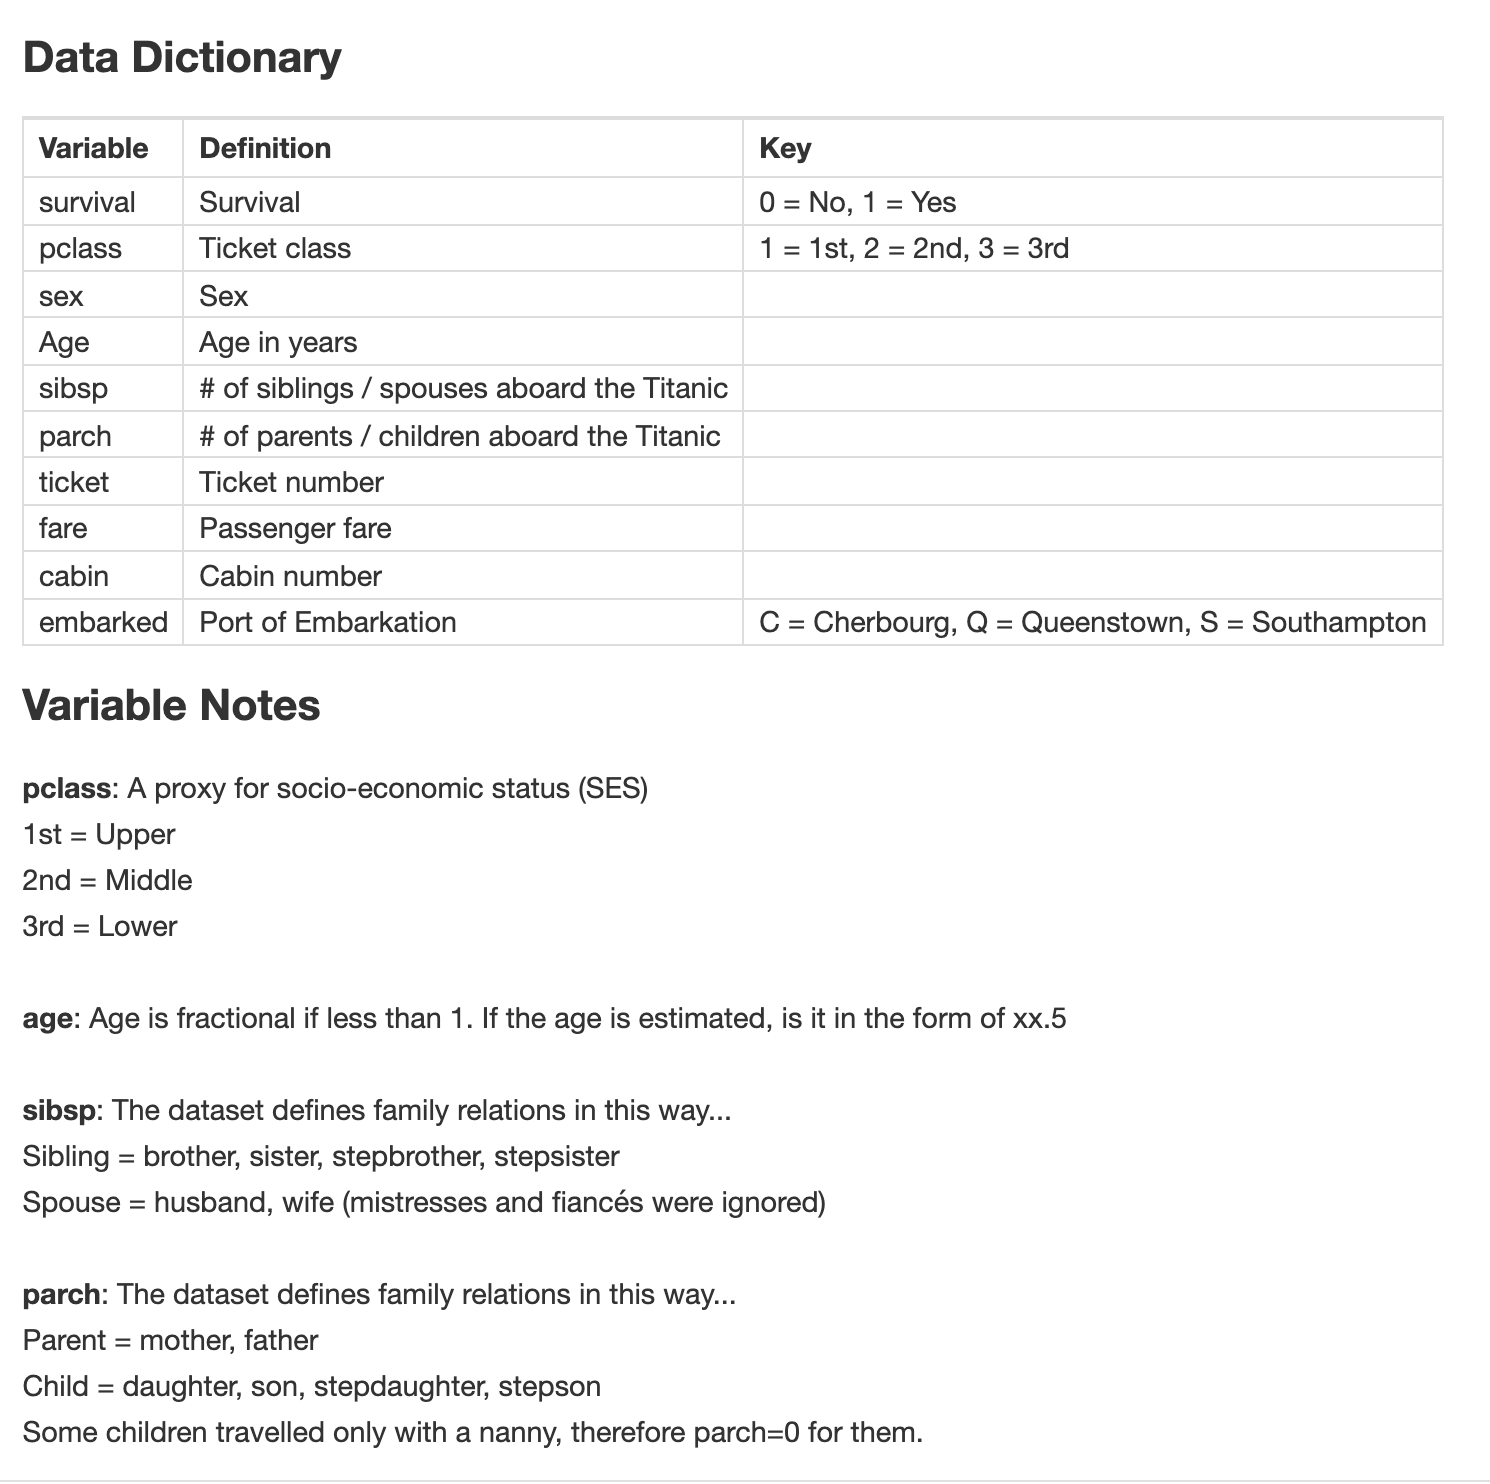

## Матрица корреляции

In [10]:
import matplotlib.pyplot as plt

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [11]:
del data['PassengerId']

## Обрабатываем пропущенные значения

In [12]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### С числовыми можно так

In [13]:
data.loc[data['Age'].isna(), 'Age'] = np.nanmedian(data['Age'])

assert not data['Age'].isna().sum()

#### Или так 

In [14]:
data['Age'].fillna(np.nanmedian(data['Age']), inplace=True)

assert not data['Age'].isna().sum()

### С категориальными так

In [15]:
from collections import Counter

counter = Counter()
counter.update(data['Embarked'])

counter.most_common()

[('S', 644), ('C', 168), ('Q', 77), (nan, 2)]

In [16]:
data.loc[data['Embarked'].isna(), 'Embarked'] = counter.most_common()[0][0]

assert not data['Embarked'].isna().sum()

### Если много пропусков, то лучше выбросить колонку

In [17]:
print('Percent of missing values in Cabin:', int(data.Cabin.isna().mean() * 100))

del data['Cabin']

Percent of missing values in Cabin: 77


In [18]:
data.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

## Feature Engineering

### Разбираемся с категориальными признаками

In [19]:
data[['Name', 'Sex', 'Embarked']]

Name     Sex Embarked
0                              Braund, Mr. Owen Harris    male        S
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female        C
2                               Heikkinen, Miss. Laina  female        S
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female        S
4                             Allen, Mr. William Henry    male        S
..                                                 ...     ...      ...
886                              Montvila, Rev. Juozas    male        S
887                       Graham, Miss. Margaret Edith  female        S
888           Johnston, Miss. Catherine Helen "Carrie"  female        S
889                              Behr, Mr. Karl Howell    male        C
890                                Dooley, Mr. Patrick    male        Q

[891 rows x 3 columns]

In [20]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
data['Sex'] = enc.fit_transform(data['Sex'])
data['Embarked'] = enc.fit_transform(data['Embarked'])
data['Pclass'] = enc.fit_transform(data['Pclass'])

In [21]:
pd.get_dummies(data['Embarked'])

0  1  2
0    0  0  1
1    1  0  0
2    0  0  1
3    0  0  1
4    0  0  1
..  .. .. ..
886  0  0  1
887  0  0  1
888  0  0  1
889  1  0  0
890  0  1  0

[891 rows x 3 columns]

In [22]:
data = data.merge(
    pd.get_dummies(data['Embarked']).add_prefix('embarked_'), 
    left_index=True, 
    right_index=True
)
data = data.merge(
    pd.get_dummies(data['Pclass']).add_prefix('pclass_'), 
    left_index=True, 
    right_index=True
)

data.head()

Survived  Pclass                                               Name  Sex  \
0         0       2                            Braund, Mr. Owen Harris    1   
1         1       0  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   
2         1       2                             Heikkinen, Miss. Laina    0   
3         1       0       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   
4         0       2                           Allen, Mr. William Henry    1   

    Age  SibSp  Parch            Ticket     Fare  Embarked  embarked_0  \
0  22.0      1      0         A/5 21171   7.2500         2           0   
1  38.0      1      0          PC 17599  71.2833         0           1   
2  26.0      0      0  STON/O2. 3101282   7.9250         2           0   
3  35.0      1      0            113803  53.1000         2           0   
4  35.0      0      0            373450   8.0500         2           0   

   embarked_1  embarked_2  pclass_0  pclass_1  pclass_2  
0           0           1         0         0         1  
1           0           0         1         0         0  
2           0           1         0         0         1  
3           0           1         1         0         0  
4           0           1         0         0         1

### Начинаем делать признаки посложнее

#### Размер семьи

In [23]:
data['Family_size'] = data['SibSp'] + data['Parch']

corr = data[['Survived', 'Family_size']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [24]:
@np.vectorize
def label_family_size(x):
    if x == 1:
        return 0
    elif x < 5:
        return 1
    elif x < 7:
        return 2
    return 3


data['Family_size'] = label_family_size(data['Family_size'])

corr = data[['Survived', 'Family_size']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

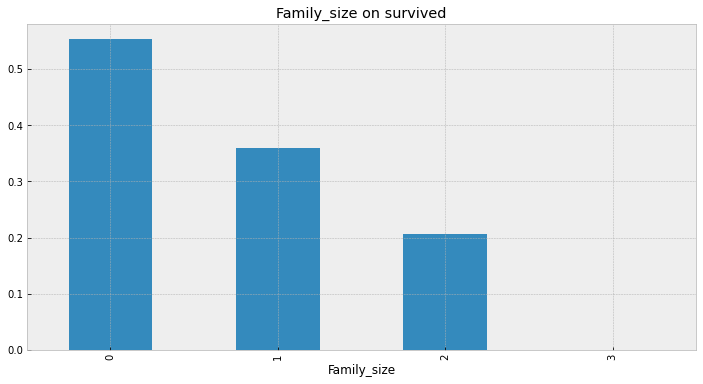

In [25]:
plt.figure(figsize=(12, 6))

plt.title('Family_size on survived')
data.groupby('Family_size')['Survived'].mean().plot.bar()

plt.show()

#### Жената ли девушка

In [26]:
data['Title'] = data['Name'].str.split(
    ', ', expand=True
)[1].str.split(
    '.', expand=True
)[0]
data['Is_Married'] = 0
data.loc[data['Title'] == 'Mrs', 'Is_Married'] = 1
data[['Name', 'Title', 'Is_Married', 'Sex']].head()

Name Title  Is_Married  Sex
0                            Braund, Mr. Owen Harris    Mr           0    1
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs           1    0
2                             Heikkinen, Miss. Laina  Miss           0    0
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs           1    0
4                           Allen, Mr. William Henry    Mr           0    1

In [27]:
data[data.Is_Married == 1].Sex.unique()

array([0])

In [28]:
data.groupby('Title')['Survived'].count().sort_values(ascending=False)

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: Survived, dtype: int64

In [29]:
@np.vectorize
def label_title(x):
    if x in ['Mr', 'Miss', 'Mrs']:
        return x
    return 'other'

data['Title'] = label_title(data['Title'])


data = data.merge(
    pd.get_dummies(data['Title']).add_prefix('title_'), 
    left_index=True, 
    right_index=True
)

data.head()

Survived  Pclass                                               Name  Sex  \
0         0       2                            Braund, Mr. Owen Harris    1   
1         1       0  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   
2         1       2                             Heikkinen, Miss. Laina    0   
3         1       0       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   
4         0       2                           Allen, Mr. William Henry    1   

    Age  SibSp  Parch            Ticket     Fare  Embarked  ...  pclass_0  \
0  22.0      1      0         A/5 21171   7.2500         2  ...         0   
1  38.0      1      0          PC 17599  71.2833         0  ...         1   
2  26.0      0      0  STON/O2. 3101282   7.9250         2  ...         0   
3  35.0      1      0            113803  53.1000         2  ...         1   
4  35.0      0      0            373450   8.0500         2  ...         0   

   pclass_1  pclass_2  Family_size  Title  Is_Married  title_Miss title_Mr  \
0         0         1            0     Mr           0           0        1   
1         0         0            0    Mrs           1           0        0   
2         0         1            1   Miss           0           1        0   
3         0         0            0    Mrs           1           0        0   
4         0         1            1     Mr           0           0        1   

   title_Mrs  title_other  
0          0            0  
1          1            0  
2          0            0  
3          1            0  
4          0            0  

[5 rows x 23 columns]

## Убираем все ненужное

In [38]:
del_cols = ['Pclass', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Title']
data = data.drop(del_cols, axis=1, errors='ignore')

In [39]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### Обучаем модель

In [40]:
x = data.copy()
y = data['Survived']

del x['Survived']

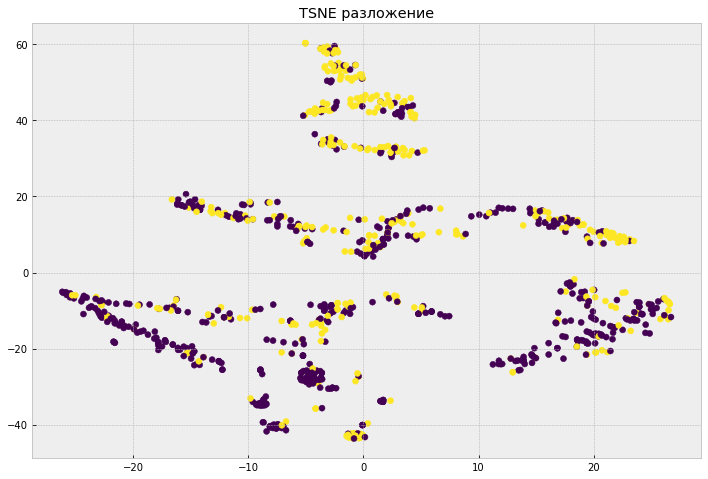

In [104]:
tsne = TSNE()
X_tsne = tsne.fit_transform(x)

plt.figure(figsize=(12,8))
plt.title('TSNE разложение')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.show()

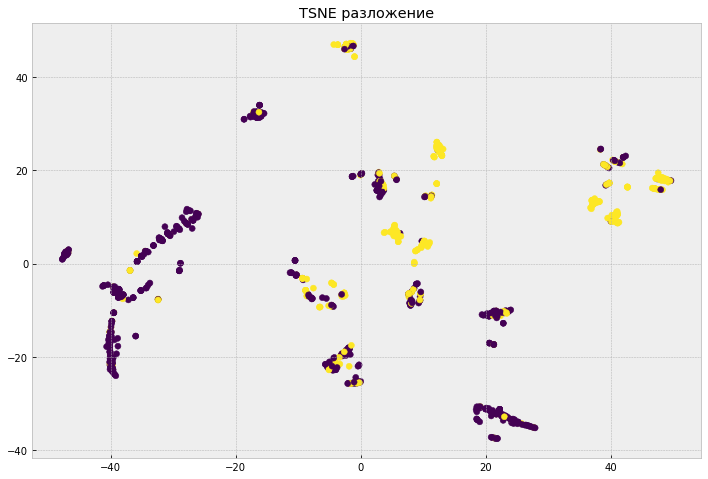

In [106]:
tsne = TSNE()
X_tsne = tsne.fit_transform(StandardScaler().fit_transform(x))

plt.figure(figsize=(12,8))
plt.title('TSNE разложение')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.show()

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_tsne, y, test_size=0.3, random_state=42)

### Логистическая регрессия

In [129]:
model = LogisticRegression(max_iter=1000)

model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       169
           1       0.69      0.78      0.73        99

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.80      0.79      0.79       268



In [130]:
model = LogisticRegression(solver='liblinear', penalty='l1')

model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       169
           1       0.70      0.79      0.74        99

    accuracy                           0.80       268
   macro avg       0.78      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268



#### Проверим, нужна ли нормализация

In [131]:
model = LogisticRegression(solver='liblinear', penalty='l1')

scaler = StandardScaler().fit(x_train)
model.fit(scaler.transform(x_train), y_train)
print(classification_report(model.predict(scaler.transform(x_test)), y_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       169
           1       0.69      0.78      0.73        99

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.80      0.79      0.79       268



In [132]:
model = LogisticRegression(penalty='l2')

scaler = StandardScaler().fit(x_train)
model.fit(scaler.transform(x_train), y_train)
print(classification_report(model.predict(scaler.transform(x_test)), y_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       169
           1       0.69      0.78      0.73        99

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.80      0.79      0.79       268



### Построим KNN

In [133]:
model = KNeighborsClassifier(n_neighbors=5)

model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       186
           1       0.51      0.70      0.59        82

    accuracy                           0.71       268
   macro avg       0.68      0.70      0.68       268
weighted avg       0.74      0.71      0.71       268



#### С нормализацией

In [134]:
model = KNeighborsClassifier(n_neighbors=10)

scaler = StandardScaler().fit(x_train)
model.fit(scaler.transform(x_train), y_train)
print(classification_report(model.predict(scaler.transform(x_test)), y_test))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       179
           1       0.68      0.84      0.75        89

    accuracy                           0.81       268
   macro avg       0.79      0.82      0.80       268
weighted avg       0.83      0.81      0.82       268



#### Проверим knn на TSNE разложении

In [135]:
model = KNeighborsClassifier(n_neighbors=10)

model.fit(x_train_t, y_train_t)
print(classification_report(model.predict(x_test_t), y_test_t))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       182
           1       0.64      0.83      0.72        86

    accuracy                           0.79       268
   macro avg       0.77      0.80      0.78       268
weighted avg       0.82      0.79      0.80       268



### Построим случайный лес и feature importance

In [136]:
model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       161
           1       0.73      0.76      0.74       107

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.79      0.79      0.79       268



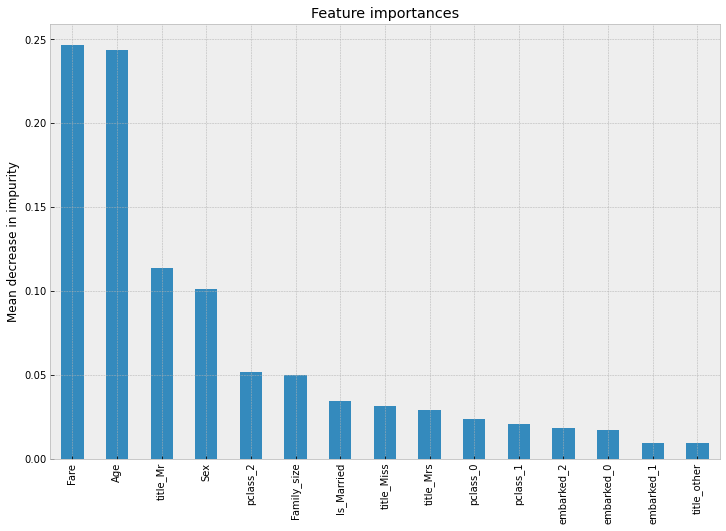

In [137]:
forest_importances = pd.Series(model.feature_importances_, index=x.columns)
forest_importances = forest_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
forest_importances.plot.bar()
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.show()

#### Возьмем лес получше

In [138]:
model = RandomForestClassifier(
    criterion='gini', 
    n_estimators=1100,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=5,
    max_features='auto',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       180
           1       0.67      0.84      0.74        88

    accuracy                           0.81       268
   macro avg       0.79      0.82      0.80       268
weighted avg       0.83      0.81      0.81       268



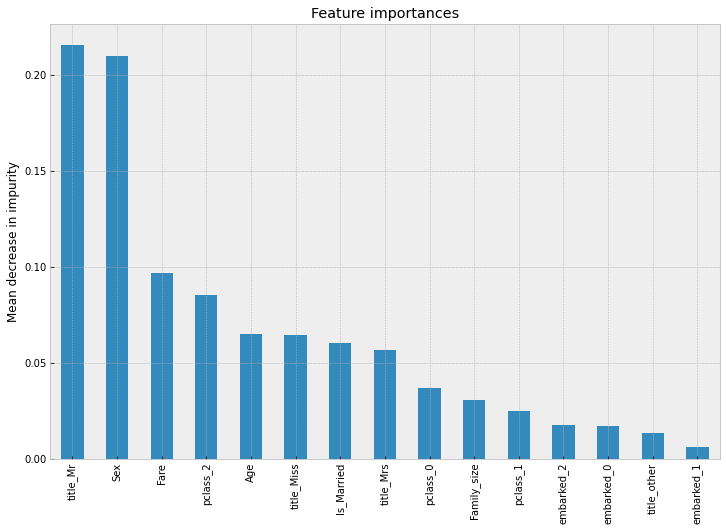

In [139]:
forest_importances = pd.Series(model.feature_importances_, index=x.columns)
forest_importances = forest_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
forest_importances.plot.bar()
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.show()

### Подберем параметры для логистической регрессии

In [158]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver='liblinear', penalty='l1')
clf = GridSearchCV(model, {'C': np.linspace(0.1, 3, 50)})
clf.fit(x_train, y_train)

model = clf.best_estimator_
model.fit(x_train, y_train)
print(classification_report(model.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       168
           1       0.71      0.79      0.75       100

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268



In [163]:
print('ROC-AUC:', round(roc_auc_score(model.predict(x_test), y_test), 5))

ROC-AUC: 0.79976


In [164]:
model

LogisticRegression(C=0.6918367346938775, penalty='l1', solver='liblinear')

#### Когда признаков мало, можно не отбирать их

In [165]:
cols = [
    'title_Mr', 'Sex', 'Fare', 'pclass_2', 'title_Miss', 'Is_Married', 'title_Mrs', 'Age'
]

model = LogisticRegression(solver='liblinear', penalty='l1')
clf = GridSearchCV(model, {'C': np.linspace(0.1, 3, 50)})
clf.fit(x_train[cols], y_train)

model = clf.best_estimator_
model.fit(x_train[cols], y_train)
print(classification_report(model.predict(x_test[cols]), y_test))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       168
           1       0.68      0.76      0.72       100

    accuracy                           0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268



### Подберем параметры для knn с TSNE

In [168]:
x_train_t.shape

(623, 2)

In [169]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()
clf = GridSearchCV(model, {'n_neighbors': np.arange(5, 15), 'p': [1, 2, 3, np.inf]})
clf.fit(x_train_t, y_train_t)

model = clf.best_estimator_
model.fit(x_train_t, y_train_t)
print(classification_report(model.predict(x_test_t), y_test_t))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       180
           1       0.66      0.83      0.73        88

    accuracy                           0.80       268
   macro avg       0.78      0.81      0.79       268
weighted avg       0.82      0.80      0.81       268



In [171]:
## У логрега на всех фичах было ROC-AUC: 0.79976
print('ROC-AUC:', round(roc_auc_score(model.predict(x_test_t), y_test_t), 5))

ROC-AUC: 0.80922


In [172]:
model

KNeighborsClassifier(n_neighbors=13, p=1)

### Заключение

В итоге мы смогли получить модель с хорошим качеством, используя всего лишь 2 признака.